In [1]:
import datetime
import os
import mthree
import numpy as np
from qiskit import Aer, BasicAer, IBMQ, transpile
from qiskit.providers.ibmq import IBMQBackend
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit_research.mzm_generation import KitaevHamiltonianExperiment
from qiskit_research.mzm_generation.utils import pick_qubit_layout

In [2]:
# get backend

# hardware backend
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
backend = provider.get_backend('ibmq_guadalupe')

# Aer simulator backend
# backend = AerSimulator(method='statevector')

In [3]:
# Hamiltonian parameters
n_modes = 6
tunneling_values = [-1.0]
superconducting_values = [1.0]
chemical_potential_values = np.linspace(1e-8, 3.1, num=5)
occupied_orbitals_list = [(0,), (0, 1, 2), (0, 1, 2, 3, 4, 5)]

# qubits
qubits, backend_name, error_score = pick_qubit_layout(n_modes, [backend])
# qubits = [0, 1, 2]
print(f'Using qubits {qubits}.')

# number of shots
shots = 100000

# number of shots for readout error calibration
readout_calibration_shots = 100000

# date
date = datetime.datetime.now().isoformat()

# create experiments
experiment = KitaevHamiltonianExperiment(
    experiment_id=f'{date}_{backend.name()}',
    backend=backend,
    readout_calibration_date=date,
    qubits=qubits,
    tunneling_values=tunneling_values,
    superconducting_values=superconducting_values,
    chemical_potential_values=chemical_potential_values,
    occupied_orbitals_list=occupied_orbitals_list,
    dynamical_decoupling_sequences=['X2pm', 'XY4pm']
)

Using qubits [14, 13, 12, 10, 7, 6].


In [4]:
%%time

# schedule readout calibration
print('Scheduling readout calibration ...')
mit = mthree.M3Mitigation(backend)
mit.cals_from_system(qubits, shots=readout_calibration_shots)

# schedule experiment jobs
circuits_per_job = 100
print(f'Scheduling experiment ...')
data = experiment.run(deflated
    circuits_per_job=circuits_per_job,
    shots=shots)
if isinstance(backend, IBMQBackend):
    data.save()

# save readout calibration
filename = f'data/readout_calibration/{backend.name()}/{date}.json'
os.makedirs(os.path.dirname(filename), exist_ok=True)
print(f'Waiting for readout calibration data ...')
mit.cals_to_file(filename)
print(f'Readout calibration saved.')

Scheduling readout calibration ...
Scheduling experiment ...
You can view the experiment online at https://quantum-computing.ibm.com/experiments/f870b155-0b7d-454a-b487-5f4362a7b90d
Waiting for readout calibration data ...
Readout calibration saved.
CPU times: user 1min 26s, sys: 712 ms, total: 1min 27s
Wall time: 39min 47s


In [5]:
# wait for experiment results
# data.block_for_results()

# TODO save data locally once it's supported
# See https://github.com/Qiskit/qiskit-experiments/issues/602

In [1]:
# TODO split off into analysis notebook once Qiskit Experiments supports saving data
# See https://github.com/Qiskit/qiskit-experiments/issues/602
import os
import matplotlib.pyplot as plt
import numpy as np
from qiskit import IBMQ
from qiskit_experiments.framework import ExperimentData
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_research.mzm_generation import KitaevHamiltonianAnalysis

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')

In [22]:
db_experiment_id = '000cdc2b-b523-4631-9b7f-48e439484230'
#db_experiment_id = '134978a1-ea17-41b5-9e59-fb3f77bf6f30'
#db_experiment_id = 'f6637a82-afe1-44bd-adce-188bf0ddd2a6'

data = ExperimentData.load(db_experiment_id, provider.service('experiment'))

In [23]:
%%time
experiment_id = data.metadata["experiment_id"]
qubits = data.metadata["qubits"]
n_modes = len(qubits)
tunneling_values = data.metadata["tunneling_values"]
superconducting_values = data.metadata["superconducting_values"]
chemical_potential_values = data.metadata["chemical_potential_values"]

# run analysis
analysis = KitaevHamiltonianAnalysis()
data = analysis.run(data)

# load results
fidelity_witness_avg_raw, fidelity_witness_stddev_raw = data.analysis_results('fidelity_witness_avg_raw').value
fidelity_witness_avg_mem, fidelity_witness_stddev_mem = data.analysis_results('fidelity_witness_avg_mem').value
fidelity_witness_avg_ps, fidelity_witness_stddev_ps = data.analysis_results('fidelity_witness_avg_ps').value
fidelity_witness_avg_pur, fidelity_witness_stddev_pur = data.analysis_results('fidelity_witness_avg_pur').value

energy_exact = data.analysis_results('energy_exact').value
energy_raw = data.analysis_results('energy_raw').value
energy_mem = data.analysis_results('energy_mem').value
energy_ps = data.analysis_results('energy_ps').value
energy_pur = data.analysis_results('energy_pur').value

edge_correlation_exact = data.analysis_results('edge_correlation_exact').value
edge_correlation_raw = data.analysis_results('edge_correlation_raw').value
edge_correlation_mem = data.analysis_results('edge_correlation_mem').value
edge_correlation_ps = data.analysis_results('edge_correlation_ps').value
edge_correlation_pur = data.analysis_results('edge_correlation_pur').value

parity_exact = data.analysis_results('parity_exact').value
parity_raw = data.analysis_results('parity_raw').value
parity_mem = data.analysis_results('parity_mem').value
parity_ps = data.analysis_results('parity_ps').value

number_exact = data.analysis_results('number_exact').value
number_raw = data.analysis_results('number_raw').value
number_mem = data.analysis_results('number_mem').value
number_ps = data.analysis_results('number_ps').value
number_pur = data.analysis_results('number_pur').value

energy_error_raw, energy_error_stddev_raw = data.analysis_results('energy_error_raw').value
energy_error_mem, energy_error_stddev_mem = data.analysis_results('energy_error_mem').value
energy_error_ps, energy_error_stddev_ps = data.analysis_results('energy_error_ps').value
energy_error_pur, energy_error_stddev_pur = data.analysis_results('energy_error_pur').value

# create plot directory
os.makedirs(f'plots/{experiment_id}', exist_ok=True)

# set plot options
dpi = 150
filetype = 'png'

CPU times: user 1min 1s, sys: 518 ms, total: 1min 2s
Wall time: 9.1 s


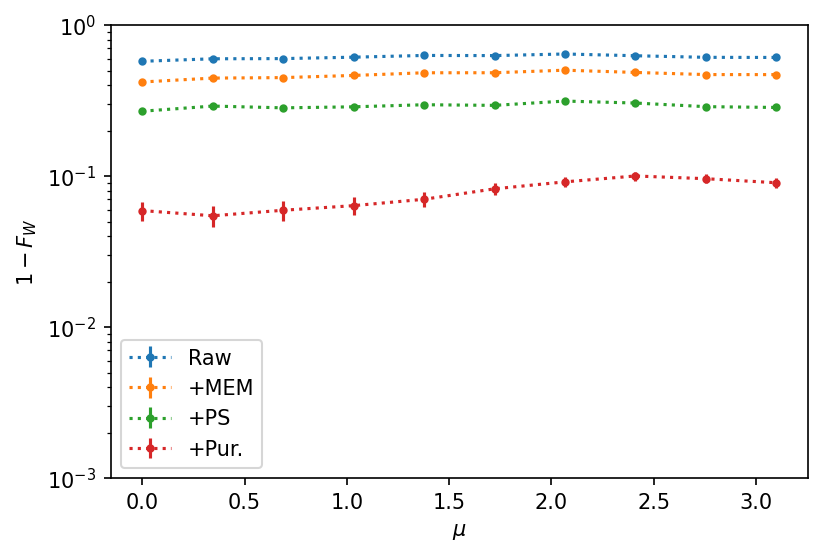

In [24]:
# plot fidelity witness
fig, ax = plt.subplots(dpi=dpi)
ax.errorbar(
    chemical_potential_values,
    1 - fidelity_witness_avg_raw,
    yerr=2 * fidelity_witness_stddev_raw,
    fmt=".:",
    label="Raw",
)
ax.errorbar(
    chemical_potential_values,
    1 - fidelity_witness_avg_mem,
    yerr=2 * fidelity_witness_stddev_mem,
    fmt=".:",
    label="+MEM",
)
ax.errorbar(
    chemical_potential_values,
    1 - fidelity_witness_avg_ps,
    yerr=2 * fidelity_witness_stddev_ps,
    fmt=".:",
    label="+PS",
)
ax.errorbar(
    chemical_potential_values,
    1 - fidelity_witness_avg_pur,
    yerr=2 * fidelity_witness_stddev_pur,
    fmt=".:",
    label="+Pur.",
)
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$1 - F_W$")
ax.set_yscale('log')
ax.set_ylim(1e-3, 1)
ax.legend()

data.add_figures(fig, 'fidelity_witness', overwrite=True)
plt.savefig(f'plots/{experiment_id}/fidelity_witness.{filetype}')
plt.show()

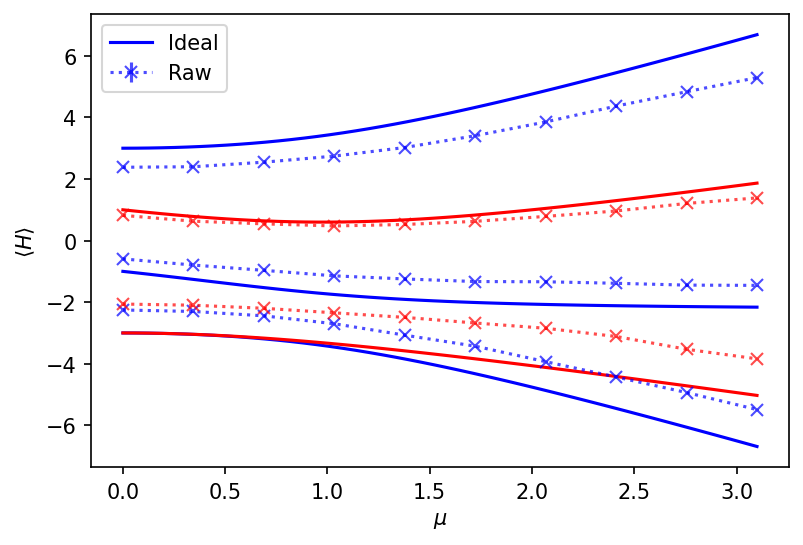

In [25]:
# plot energy, raw data only
fig, ax = plt.subplots(dpi=dpi)
for occupied_orbitals, (energies, xvals) in energy_exact.items():
    label = "Ideal" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(
        xvals, energies, label=label, color=color
    )
for occupied_orbitals, (energies, stddevs) in energy_raw.items():
    label = "Raw" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt="x:",
        label=label,
        color=color,
        alpha=0.7,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle H \rangle$")
ax.legend()

data.add_figures(fig, 'energy_raw', overwrite=True)
plt.show()

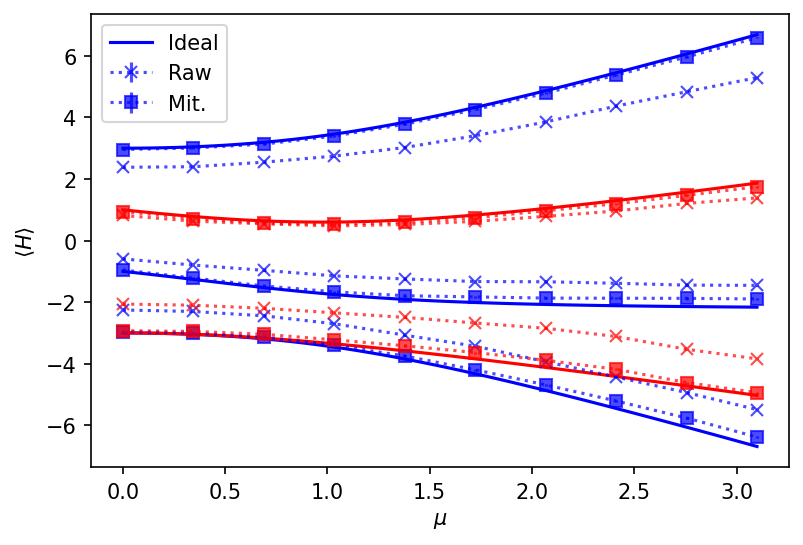

In [26]:
# plot energy, raw data plus error mitigation
fig, ax = plt.subplots(dpi=dpi)
#occupied_orbitals_list = [(), (0,)]
occupied_orbitals_list = [tuple(o) for o in data.metadata["occupied_orbitals_list"]]
for occupied_orbitals in occupied_orbitals_list:
    energies, xvals = energy_exact[occupied_orbitals]
    label = "Ideal" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(
        xvals, energies, label=label, color=color
    )
for occupied_orbitals in occupied_orbitals_list:
    energies, stddevs = energy_raw[occupied_orbitals]
    label = "Raw" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt="x:",
        label=label,
        color=color,
        alpha=0.7,
    )
for occupied_orbitals in occupied_orbitals_list:
    energies, stddevs = energy_pur[occupied_orbitals]
    label = "Mit." if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt="s:",
        label=label,
        color=color,
        alpha=0.7,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle H \rangle$")
#ax.set_ylim(-5.2, -1)
ax.legend()

data.add_figures(fig, 'energy_mit', overwrite=True)
plt.savefig(f'plots/{experiment_id}/energy_mit.{filetype}')
plt.show()

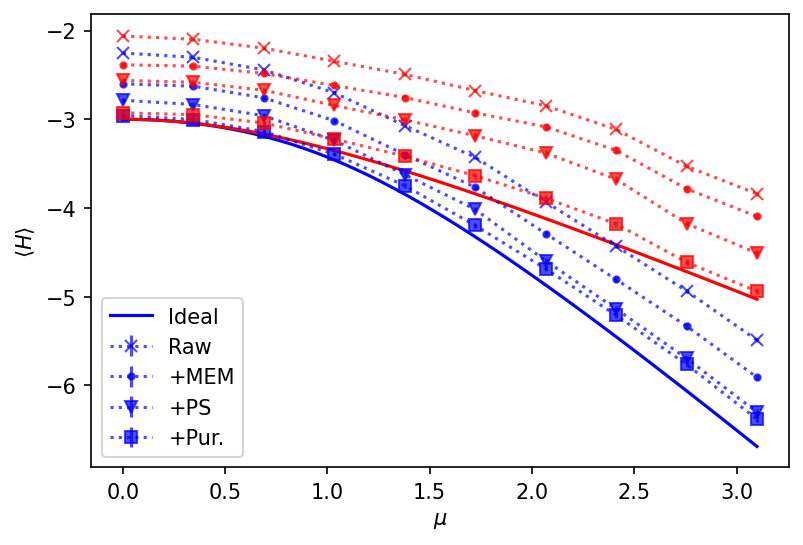

In [27]:
# plot energy, raw data plus error mitigation
fig, ax = plt.subplots(dpi=dpi)
occupied_orbitals_list = [(), (0,)]
# occupied_orbitals_list = [tuple(o) for o in data.metadata["occupied_orbitals_list"]]
for occupied_orbitals in occupied_orbitals_list:
    energies, xvals = energy_exact[occupied_orbitals]
    label = "Ideal" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(
        xvals, energies, label=label, color=color
    )
for occupied_orbitals in occupied_orbitals_list:
    energies, stddevs = energy_raw[occupied_orbitals]
    label = "Raw" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt="x:",
        label=label,
        color=color,
        alpha=0.7,
    )
for occupied_orbitals in occupied_orbitals_list:
    energies, stddevs = energy_mem[occupied_orbitals]
    label = "+MEM" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt=".:",
        label=label,
        color=color,
        alpha=0.7,
    )
for occupied_orbitals in occupied_orbitals_list:
    energies, stddevs = energy_ps[occupied_orbitals]
    label = "+PS" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt="v:",
        label=label,
        color=color,
        alpha=0.7,
    )
for occupied_orbitals in occupied_orbitals_list:
    energies, stddevs = energy_pur[occupied_orbitals]
    label = "+Pur." if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt="s:",
        label=label,
        color=color,
        alpha=0.7,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle H \rangle$")
ax.legend()

data.add_figures(fig, 'energy_mit', overwrite=True)
plt.show()

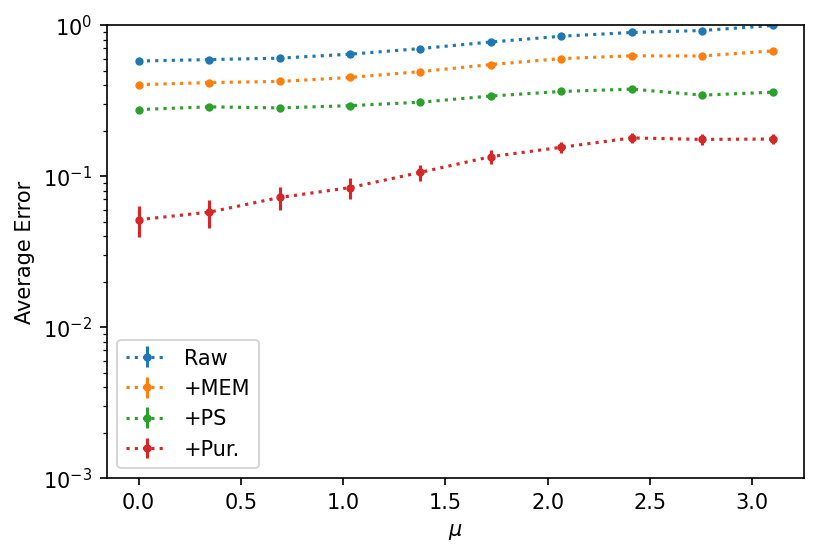

In [28]:
# plot average error in energy
fig, ax = plt.subplots(dpi=dpi)
ax.errorbar(
    chemical_potential_values,
    energy_error_raw,
    yerr=2 * energy_error_stddev_raw,
    fmt=".:",
    label="Raw",
)
ax.errorbar(
    chemical_potential_values,
    energy_error_mem,
    yerr=2 * energy_error_stddev_mem,
    fmt=".:",
    label="+MEM",
)
ax.errorbar(
    chemical_potential_values,
    energy_error_ps,
    yerr=2 * energy_error_stddev_ps,
    fmt=".:",
    label="+PS",
)
ax.errorbar(
    chemical_potential_values,
    energy_error_pur,
    yerr=2 * energy_error_stddev_pur,
    fmt=".:",
    label="+Pur.",
)
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"Average Error")
ax.set_yscale('log')
ax.set_ylim(1e-3, 1)
ax.legend()

data.add_figures(fig, 'energy_error', overwrite=True)
plt.savefig(f'plots/{experiment_id}/energy_error.{filetype}')
plt.show()

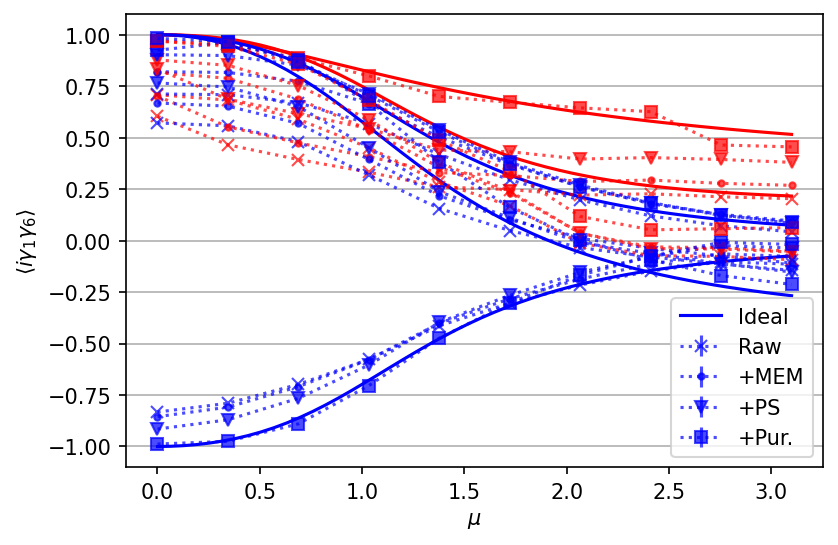

In [29]:
# plot edge correlation
fig, ax = plt.subplots(dpi=dpi)
for occupied_orbitals, (edge_correlations, xvals) in edge_correlation_exact.items():
    label = "Ideal" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(xvals, edge_correlations, label=label, color=color)
for occupied_orbitals, (edge_correlations, stddevs) in edge_correlation_raw.items():
    label = "Raw" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        edge_correlations,
        yerr=2 * np.array(stddevs),
        fmt="x:",
        label=label,
        color=color,
        alpha=0.7
    )
for occupied_orbitals, (edge_correlations, stddevs) in edge_correlation_mem.items():
    label = "+MEM" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        edge_correlations,
        yerr=2 * np.array(stddevs),
        fmt=".:",
        label=label,
        color=color,
        alpha=0.7
    )
for occupied_orbitals, (edge_correlations, stddevs) in edge_correlation_ps.items():
    label = "+PS" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        edge_correlations,
        yerr=2 * np.array(stddevs),
        fmt="v:",
        label=label,
        color=color,
        alpha=0.7
    )
for occupied_orbitals, (edge_correlations, stddevs) in edge_correlation_pur.items():
    label = "+Pur." if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        edge_correlations,
        yerr=2 * np.array(stddevs),
        fmt="s:",
        label=label,
        color=color,
        alpha=0.7
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle i \gamma_1 \gamma_6 \rangle$")
ax.grid(axis='y')
ax.legend()

data.add_figures(fig, 'edge_correlation_raw_mem', overwrite=True)
plt.show()

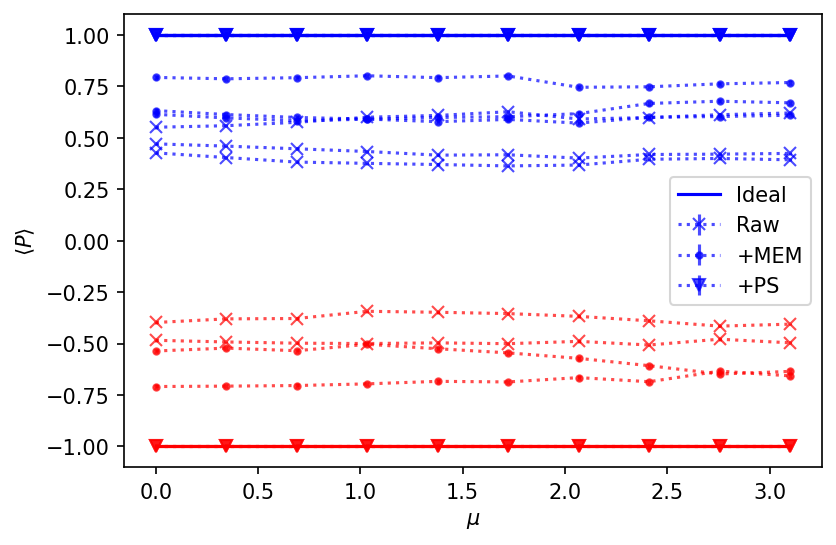

In [30]:
# plot parity
fig, ax = plt.subplots(dpi=dpi)
for occupied_orbitals, (parities, xvals) in parity_exact.items():
    label = "Ideal" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(xvals, parities, label=label, color=color)
for occupied_orbitals, (parities, stddevs) in parity_raw.items():
    label = "Raw" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        parities,
        yerr=2 * np.array(stddevs),
        fmt="x:",
        label=label,
        color=color,
        alpha=0.7,
    )
for occupied_orbitals, (parities, stddevs) in parity_mem.items():
    label = "+MEM" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        parities,
        yerr=2 * np.array(stddevs),
        fmt=".:",
        label=label,
        color=color,
        alpha=0.7,
    )
for occupied_orbitals, (parities, stddevs) in parity_ps.items():
    label = "+PS" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        parities,
        yerr=2 * np.array(stddevs),
        fmt="v:",
        label=label,
        color=color,
        alpha=0.7,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle P \rangle$")
ax.set_ylim(-1.1, 1.1)
ax.legend()

data.add_figures(fig, 'parity_raw_mem', overwrite=True)
plt.show()

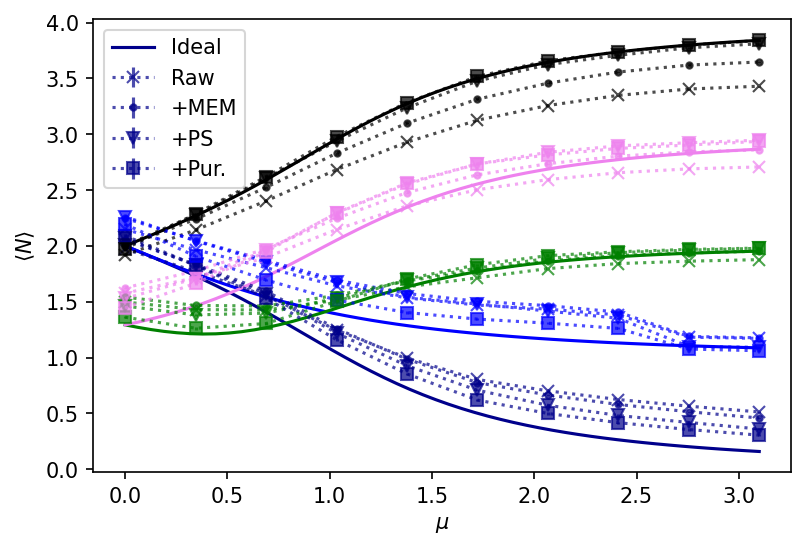

In [31]:
# plot number
fig, ax = plt.subplots(dpi=dpi)
colors = {
    (): "darkblue",
    (0,): "blue",
    (1,): "cyan",
    (2,): "greenyellow",
    (0, 1): "green",
    (0, 2): "orange",
    (1, 2): "red",
    (0, 1, 2): "violet",
    (0, 1, 2, 3): "black",
}
for occupied_orbitals, (numbers, xvals) in number_exact.items():
    label = "Ideal" if not occupied_orbitals else None
    ax.plot(
        xvals,
        numbers,
        label=label,
        color=colors[occupied_orbitals],
    )
for occupied_orbitals, (numbers, stddevs) in number_raw.items():
    label = "Raw" if not occupied_orbitals else None
    ax.errorbar(
        chemical_potential_values,
        numbers,
        yerr=2 * np.array(stddevs),
        fmt="x:",
        label=label,
        color=colors[occupied_orbitals],
        alpha=0.7,
    )
for occupied_orbitals, (numbers, stddevs) in number_mem.items():
    label = "+MEM" if not occupied_orbitals else None
    ax.errorbar(
        chemical_potential_values,
        numbers,
        yerr=2 * np.array(stddevs),
        fmt=".:",
        label=label,
        color=colors[occupied_orbitals],
        alpha=0.7,
    )
for occupied_orbitals, (numbers, stddevs) in number_ps.items():
    label = "+PS" if not occupied_orbitals else None
    ax.errorbar(
        chemical_potential_values,
        numbers,
        yerr=2 * np.array(stddevs),
        fmt="v:",
        label=label,
        color=colors[occupied_orbitals],
        alpha=0.7,
    )
for occupied_orbitals, (numbers, stddevs) in number_pur.items():
    label = "+Pur." if not occupied_orbitals else None
    ax.errorbar(
        chemical_potential_values,
        numbers,
        yerr=2 * np.array(stddevs),
        fmt="s:",
        label=label,
        color=colors[occupied_orbitals],
        alpha=0.7,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle N \rangle$")
ax.legend()

data.add_figures(fig, 'number_raw_mem', overwrite=True)
plt.show()